### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from filtering.enkf import EnKF
from model.linear2D import Linear2D
from model.parameter import Parameter
from utils import default_generator
from utils.plotter import Plotter


### Parameters

In [2]:
generator = default_generator

init_state = np.array([np.pi / 2, 6.5])
init_state_cov = 0.5 * np.eye(len(init_state))
n_states = len(init_state)
n_obs = 2

p1 = -2
p2 = -0.5
params = [
    Parameter(p1, uncertainty=1, name="$p_1$", estimate=True),
    Parameter(p2, uncertainty=1, name="$p_2$", estimate=True),
]

H = lambda _: np.eye(n_obs)
system_cov = lambda _: 0.03 * np.eye(n_states)
obs_cov = lambda _: 0.01 * np.eye(n_obs)

time_step = 0.1
init_time = 0
end_time = 30

### Generate true state

In [3]:
model = Linear2D(init_state, time_step, params, H, system_cov, obs_cov, generator)
times, states = model.integrate(init_time, end_time)

### Generate observations (with noise)

In [4]:
assimilation_times = np.arange(1, end_time, 1)
observed = np.zeros((n_obs, len(assimilation_times)))
observed_true = np.zeros((n_obs, len(assimilation_times)))
for i, t in enumerate(assimilation_times):
    k = int(t / time_step)
    observed[:, i] = model.observe(states[:, k], add_noise=True)
    observed_true[:, i] = model.observe(states[:, k])

### EnKF twin experiment

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 43.28it/s]


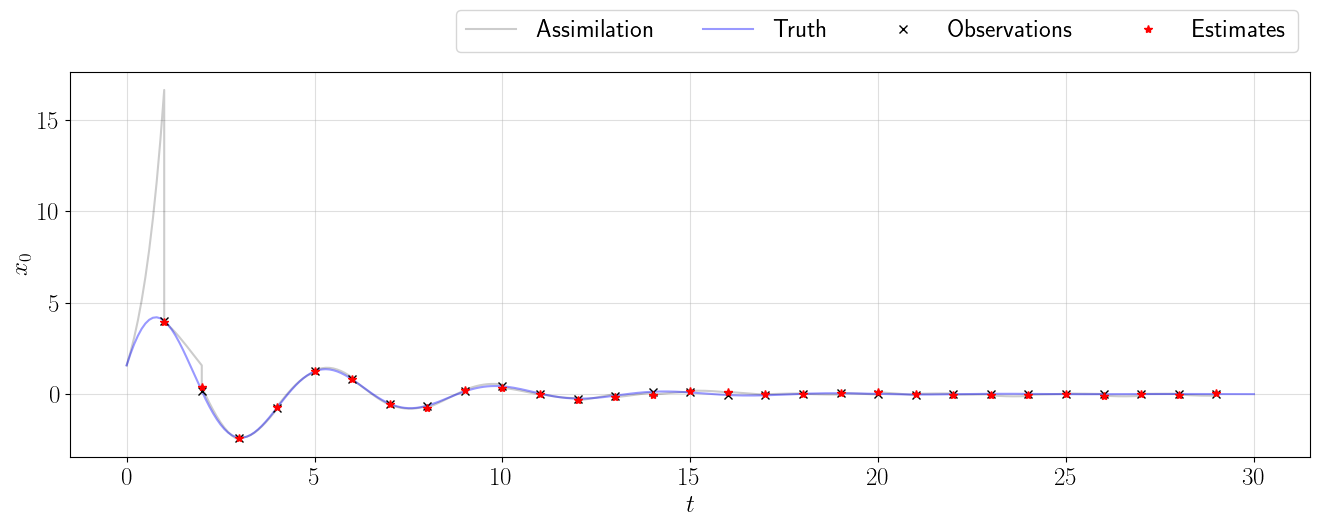

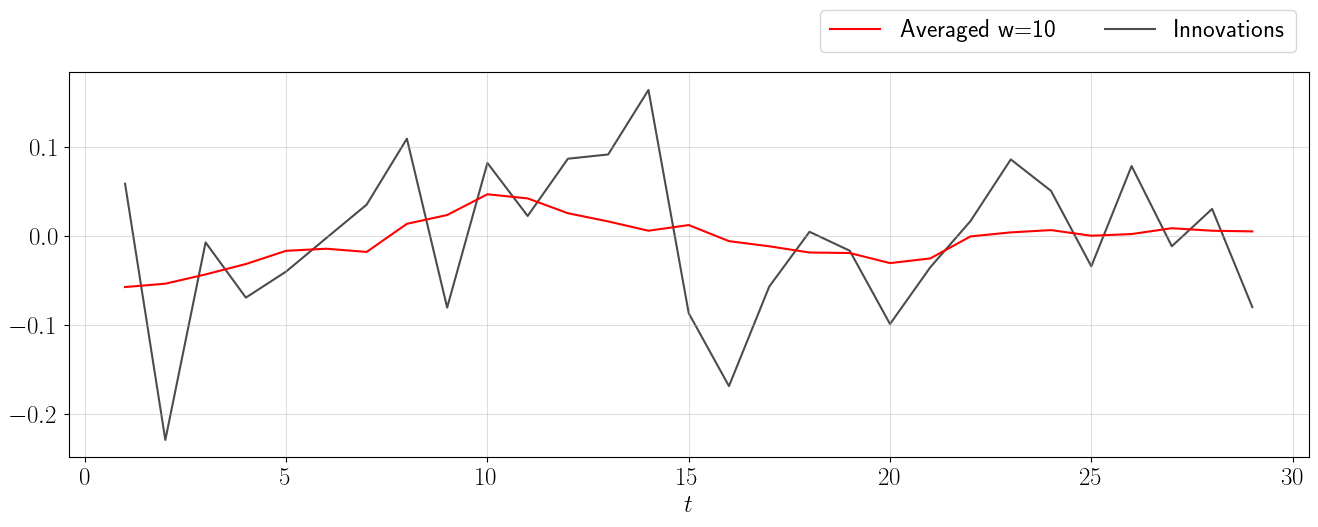

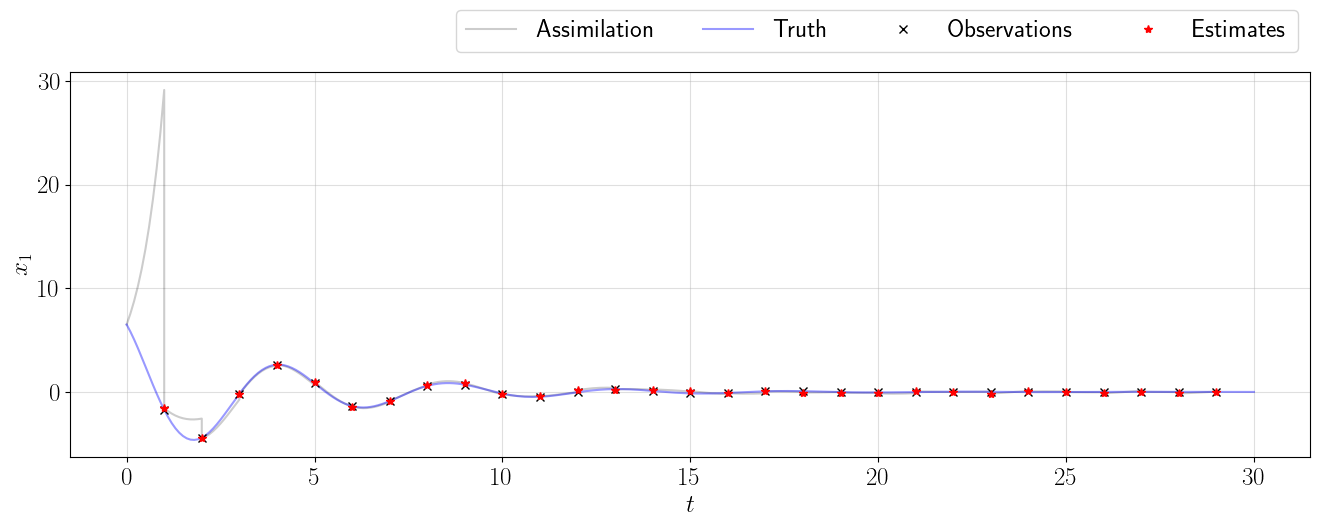

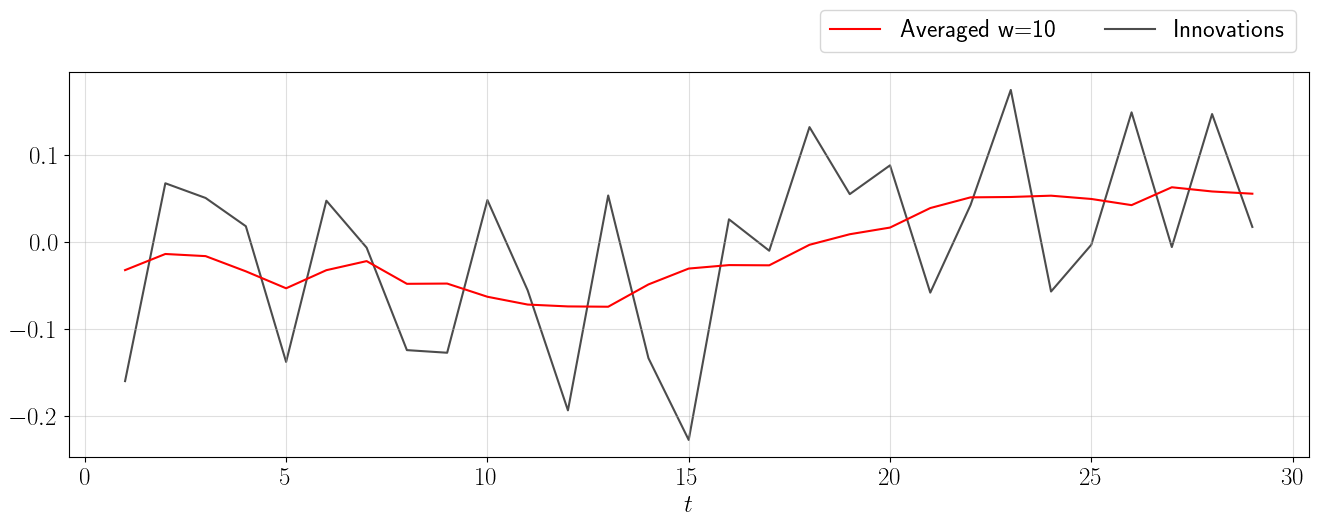

In [5]:
ensemble_size = 40
assimilation_data = observed

model.reset_model()
model.uncertain_parameters = np.array([p1 + 2, p2 + 2])

# f = KF(model, init_state, init_state_cov, generator)
f = EnKF(model, init_state, init_state_cov, ensemble_size, H)

results = f.filter(
    assimilation_times.tolist(),
    observed_true,
    cut_off_time=None,
)
results.true_times = times
results.true_states = states

window = int(end_time / 3)
for i in range(2):
    results.plot_filtering(i)
    results.plot_innovations(i, window=window)

<Axes: xlabel='Time'>

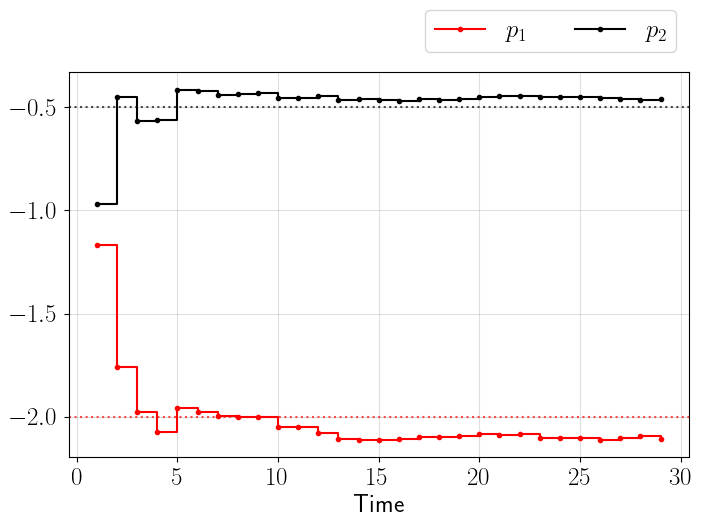

In [6]:
refs = [p1, p2]
results.plot_params([0, 1], refs)